# Assigment 3
#### In this assigment you fetch a dataset, explore it, and perform ML to predict the survival of a given person in the Titanic disaster.

These first cells are given and you should not (hopefully) need to touch them...

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})

### We shall simulate our own Kaggle competition: [titanic](https://www.kaggle.com/c/titanic)
We can download the data used fromm openML so no need to sign up into Kaggle if you don't want to. However, if you get stuck there are a lot of instructions/resources in Kaggle to get you going.

The point of the assignment is to explore the kind of information you can extract from the provided dataset. In this notebook you find some questions that ought to make guide you if stuck, but you can figure out interesting questions yourselves and answer those - maybe you can find something that I (or others) have not spotted. Try to build understanding of who were likely to survive. Use this understanding to build a simple model that can make predictions if a given person did survive before proceeding to using scikit-learn to make similar predictions. The more elaborate classifiers ought to beat you simple dummy model!

***
We shall not do much statistics here and you can omit confidence intervals etc., the probability for survival in a group of people $G$ can be expressed as:

$
p_\text{survival}(G) = \frac{n_\text{survived}(G)}{n_\text{people}(G)} = \frac{1}{|G|} \sum_{i \in G} S_i = \text{mean}(S(G)),
$

where $|G|$ is the number of people in group $G$ and $S_i$ is the Survived column value ({0, 1}) of person i. 

In [2]:
# https://www.kaggle.com/c/titanic
from sklearn.impute import SimpleImputer # Well use imputation to fix the missing values
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split

random_state = 34

filler = ColumnTransformer(
            [('const', SimpleImputer(strategy='constant', fill_value='missing'), ['Cabin', 'Embarked', 'Sex']),
             ('mean', SimpleImputer(strategy='mean'), ['Age', 'Fare']),
             ('pass', 'passthrough', ['Pclass', 'Sibsp', 'Parch'])])


# Store the features here, since they are needed later, note that the order needs to match with above!!
features = np.array(['Cabin', 'Embarked', 'Sex', 'Age', 'Fare', 'Pclass', 'Sibsp', 'Parch'])

    
def __map_cabin(cabin):
    if isinstance(cabin, float):
        if np.isnan(cabin): 
            return 0
    elif isinstance(cabin, int):
        return cabin
    elif isinstance(cabin, str):
        for i, cclass in enumerate('ABCDEFG'):
            if cabin.startswith(cclass): 
                return i+1
        return -1
    elif cabin is None: 
        return -1

def check_data(data):
    b = pd.DataFrame()
    b['count null'] = data.isnull().sum(axis=0) 
    b['count unique'] = data.nunique()
    b['dtype'] = data.dtypes
    display(b)


def get_data():
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    X = X.drop(columns=['boat', 'home.dest', 'body', 'name', 'ticket'])
    
    X.columns = [c[0].upper() + c[1:] for c in X.columns]
    y.name = 'Survived'
    y = y.astype(int)
    
    print('Before imputing:')
    check_data(X)
    
    dtype_dict = {'Pclass':int,
                  'Parch':int, 
                  'Sibsp':int, 
                  'Sex':'category',
                  'Cabin':'category',
                  'Embarked':'category',
                  'Age':float,
                  'Fare':float} 
 
    X.Cabin = X.Cabin.apply(__map_cabin, convert_dtype=True)
    X.Embarked = X.Embarked.fillna('S')
    
    X = filler.fit_transform(X)
    
    X = pd.DataFrame(data=X, columns=features).astype(dtype_dict)
    
    print('After imputing:')
    check_data(X)
    
    
    return train_test_split(X, y, random_state=random_state)

    
X, _, y, _ = get_data()
data = pd.concat((X, y), axis=1)
data.head()

Before imputing:


,count null,count unique,dtype
Pclass,0,3,float64
Sex,0,2,category
Age,263,98,float64
Sibsp,0,7,float64
Parch,0,8,float64
Fare,1,281,float64
Cabin,1014,186,object
Embarked,2,3,category


After imputing:


,count null,count unique,dtype
Cabin,0,8,category
Embarked,0,3,category
Sex,0,2,category
Age,0,99,float64
Fare,0,282,float64
Pclass,0,3,int64
Sibsp,0,7,int64
Parch,0,8,int64


,Cabin,Embarked,Sex,Age,Fare,Pclass,Sibsp,Parch,Survived
1264,-1,S,male,40.500000,14.5000,3,0,2,0
1089,-1,S,male,20.000000,9.2250,3,0,0,0
767,-1,S,male,29.881135,7.8958,3,0,0,0
516,6,S,male,36.500000,26.0000,2,0,2,0
116,3,S,female,60.000000,263.0000,1,1,4,1


pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Start exploring:
***

#### What was the overall probability of survival?

In [3]:
data.Survived.mean()

0.3781855249745158

#### What are the age distributions? (Maybe sns.histplot)

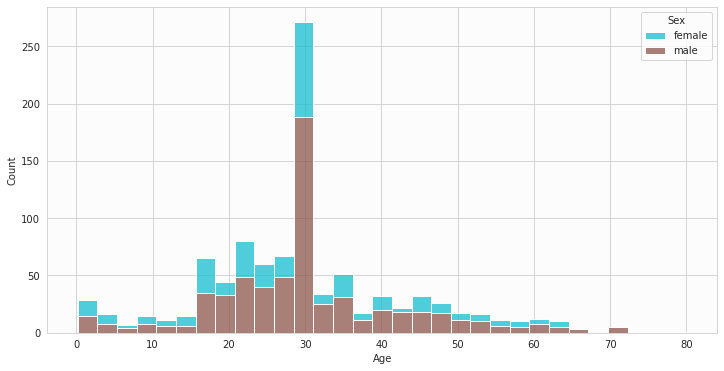

In [4]:
sex_palette={'male':'C5', 'female':'C9'}

_ = sns.histplot(x=data.Age, hue=data.Sex, data=data, palette=sex_palette, multiple='stack')

#### How about the ages in different Pclasses? (sns.boxplot ?)

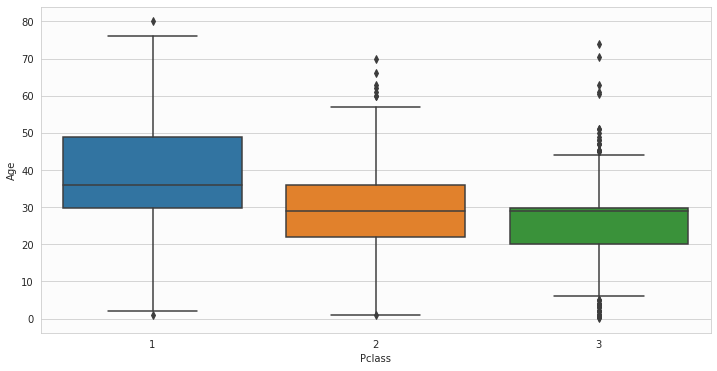

In [5]:
_ = sns.boxplot(x='Pclass', y='Age', data=data)

#### Number of tickest sold in different fare classes? (sns.histplot)

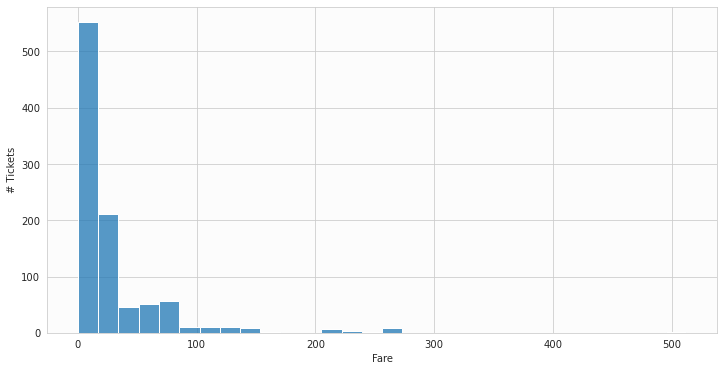

In [6]:
ax = sns.histplot(data.Fare, bins=30, kde=False)
_ = ax.set_ylabel('# Tickets')

#### How does the survival probabilty depend on the ticket class and age of a passanger? (sns.barplot function=mean)

You will need to create a groups of passangers based on their age using: pd.cut(data.Age, nbins, precision=0) - you can use this as hue for different bars..

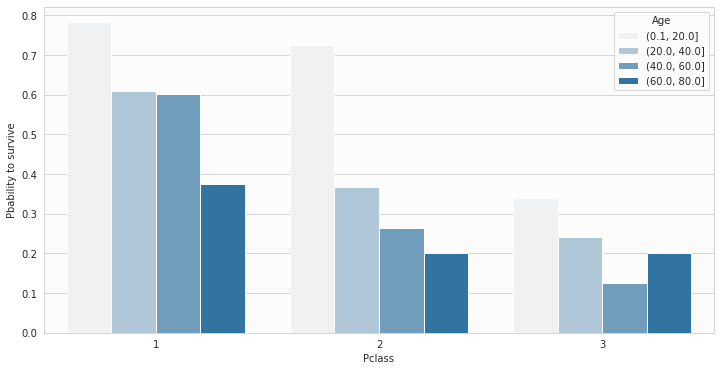

In [7]:
ci = None #90 #
ax = sns.barplot(x=data.Pclass, 
                 y=data.Survived, 
                 hue=pd.cut(data.Age, 4, precision=0),        
                 color='C0', capsize=.03, errwidth=2, ci=ci)

_ = ax.set_ylabel('Pbability to survive')

#### Can you figure out the number of survived/died people by age? (hist) 

The Survived needs to expressed as boolean and supplied to the hue...

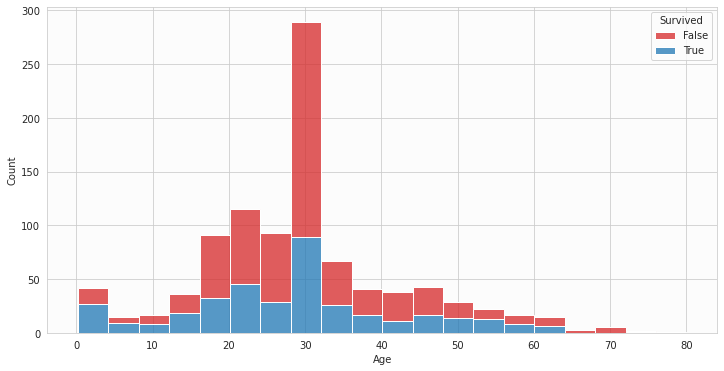

In [8]:
survived_palette = {0:'C3', 1:'C0'}

ax = sns.histplot(x=data.Age, hue=data.Survived.astype(bool), 
                  bins=20, 
                  palette=survived_palette, 
                  multiple='stack')


#### Is there some differences in survival probabilities between sexes in different age groups?

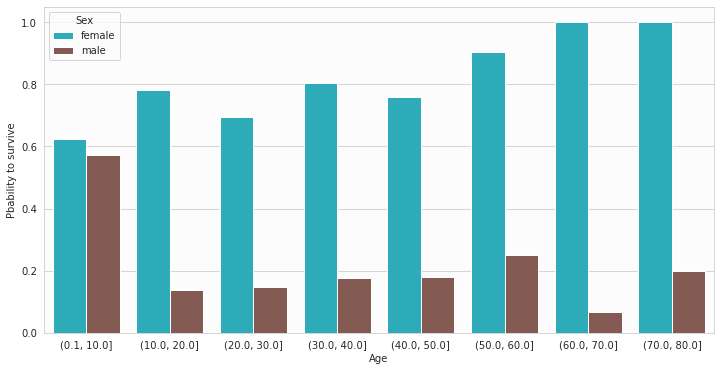

In [9]:
ax = sns.barplot(x=pd.cut(data.Age, 8, precision=0), 
                 y=data.Survived, 
                 hue=data.Sex, palette=sex_palette,
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How about probability to survive in different fare classes?

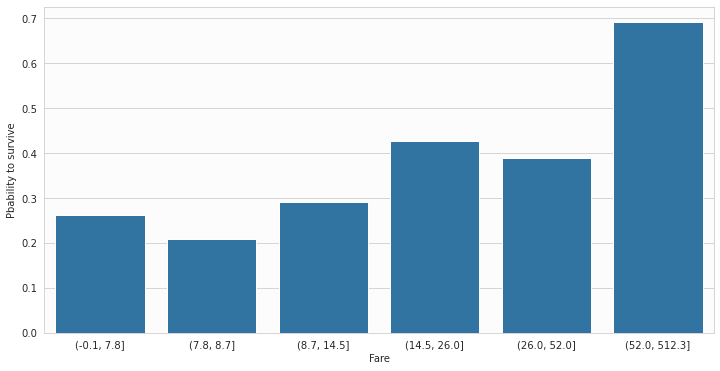

In [10]:
ax = sns.barplot(x=pd.qcut(data.Fare, 6, precision=1), 
                 y=data.Survived, 
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How does the Sex affect the survival probability in different fare classes?

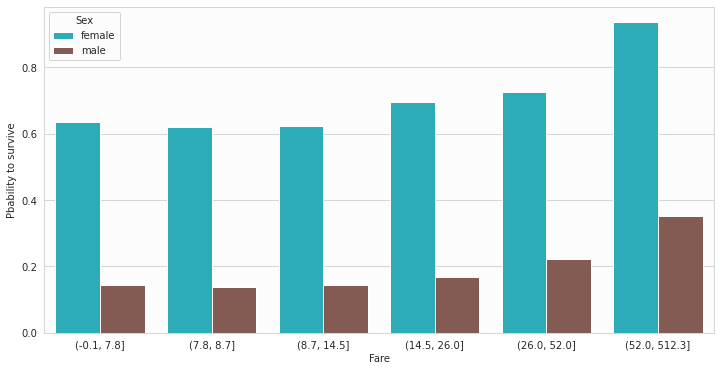

In [11]:
ax = sns.barplot(x=pd.qcut(data.Fare, 6, precision=1), 
                 y=data.Survived, 
                 hue=data.Sex, palette=sex_palette,
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How about age?

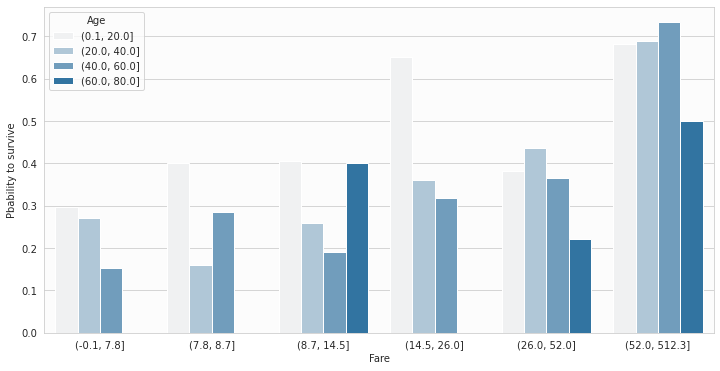

In [12]:
ax = sns.barplot(x=pd.qcut(data.Fare, 6, precision=1), 
                 y=data.Survived, 
                 hue=pd.cut(data.Age, 4, precision=0), 
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How does different numerical features correlate in the training data? (This is optional do it unless you know what correlation means...)

You can use data.corr() to abtain the correlation matrix and sns.heatmap to plot it.

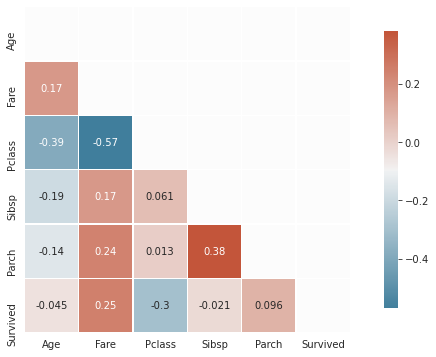

In [13]:
corr = data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
_ = sns.heatmap(corr, 
                cmap=cmap, 
                square=True, 
                linewidths=.5, 
                annot=True, 
                mask=mask, 
                cbar_kws={"shrink": .85})

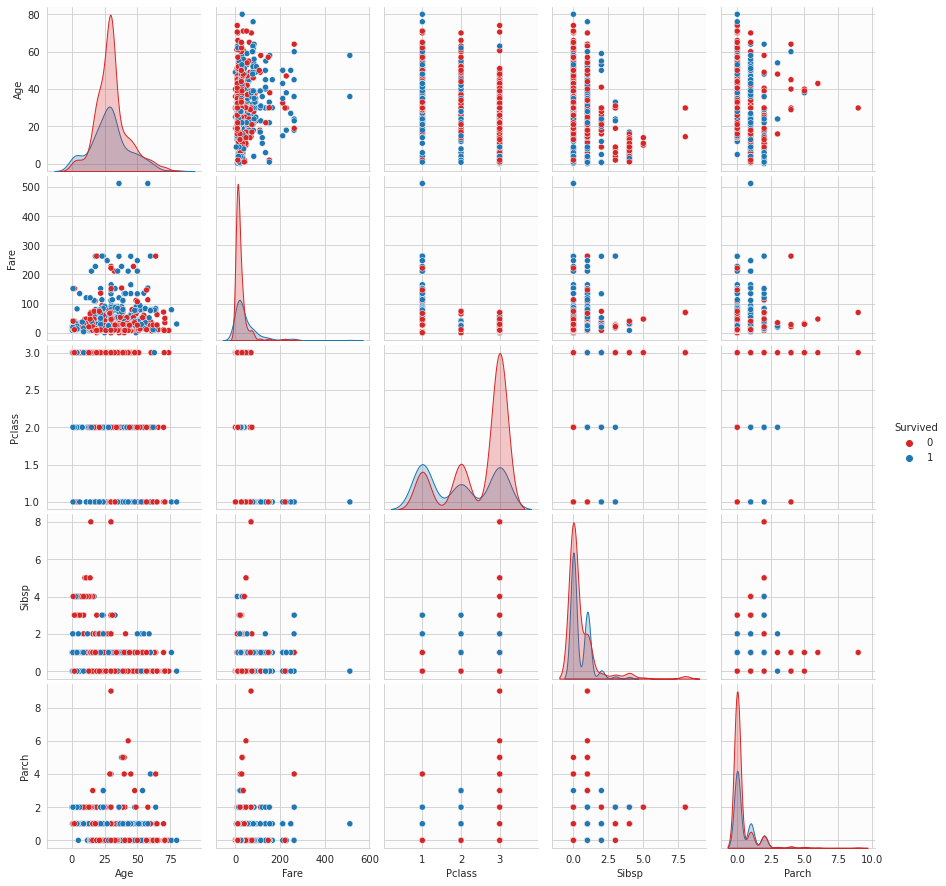

In [14]:
survived_palette = {0:'C3', 1:'C0'}
ax = sns.pairplot(data, hue='Survived', palette=survived_palette)

## Start modeling:
***
We are about to start the ML part of the assigment. However, before that make a dummy classifier that you think you are going to beat with fancy classifer.

In [15]:
def dummy_clf(X): 
    """
    Attr:
        X : data that you have formatted to be used with the other classifiers as well.
    Returns:
        y : boolean array is item y[i] = True if X[i] survived and False otherwise.
    """
    
    return np.ones(len(X), dtype=bool)

def dummy_clf(X): 
    sexarr = X.Sex
    return (sexarr == 'female') #| (X.Fare > 50)

#### Perform train valid splitting - the test sets you are only going to use in the last cell!

That is split the X_train into X_train and X_valid...

In [16]:
# Variables with undersocre at end you should not modify!
X_train, X_test_, y_train, y_test_ = get_data() 

# Split the train set alson into validation set. You are not allowed to touch the test set - it is only used in the final evaluation of your performance.
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, random_state=random_state) 

display(X_train_.head())
y_train_.head()

Before imputing:


,count null,count unique,dtype
Pclass,0,3,float64
Sex,0,2,category
Age,263,98,float64
Sibsp,0,7,float64
Parch,0,8,float64
Fare,1,281,float64
Cabin,1014,186,object
Embarked,2,3,category


After imputing:


,count null,count unique,dtype
Cabin,0,8,category
Embarked,0,3,category
Sex,0,2,category
Age,0,99,float64
Fare,0,282,float64
Pclass,0,3,int64
Sibsp,0,7,int64
Parch,0,8,int64


,Cabin,Embarked,Sex,Age,Fare,Pclass,Sibsp,Parch
64,5,S,male,27.000000,53.10,1,1,0
12,2,C,female,24.000000,69.30,1,0,0
1001,-1,Q,female,29.881135,23.25,3,2,0
896,-1,S,male,49.000000,0.00,3,0,0
210,3,S,male,55.000000,30.50,1,0,0


64      1
12      1
1001    1
896     0
210     0
Name: Survived, dtype: int64

### Encode the categorical features into numerical ones. Remember to apply the encoder in all the train, valid, and test sets. 

Also if you need to do some other preprocessing before feeding the data to the classifier do it now. Do not manipulate the X_xxx_, but create you own encoded sets, like X_train_enc etc.  

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

encoder = ColumnTransformer([('cat', OrdinalEncoder(), make_column_selector(dtype_include=['category', object]))],
                              remainder='passthrough')
scaler = Pipeline([('encode', encoder), ('scale', StandardScaler())])


# Use the pipes to preprocess the daat into two possible formats:
X_train_enc = pd.DataFrame(data=encoder.fit_transform(X_train_), index=X_train_.index, columns=[f+'_enc' for f in features]) #pd.DataFrame(data=enc_data, columns=[f+'_enc' for f in features])
X_valid_enc = pd.DataFrame(data=encoder.transform(X_valid_), index=X_valid_.index, columns=[f+'_enc' for f in features])
X_test_enc = pd.DataFrame(data=encoder.transform(X_test_), index=X_test_.index, columns=[f+'_enc' for f in features])

X_train_sc = pd.DataFrame(data=scaler.fit_transform(X_train_), index=X_train_.index, columns=[f+'_sc' for f in features])
X_valid_sc = pd.DataFrame(data=scaler.transform(X_valid_), index=X_valid_.index, columns=[f+'_sc' for f in features])
X_test_sc = pd.DataFrame(data=scaler.transform(X_test_), index=X_test_.index, columns=[f+'_sc' for f in features])


display(X_train_enc.head())
display(X_train_sc.head())

,Cabin_enc,Embarked_enc,Sex_enc,Age_enc,Fare_enc,Pclass_enc,Sibsp_enc,Parch_enc
64,5.0,2.0,1.0,27.000000,53.10,1.0,1.0,0.0
12,2.0,0.0,0.0,24.000000,69.30,1.0,0.0,0.0
1001,0.0,1.0,0.0,29.881135,23.25,3.0,2.0,0.0
896,0.0,2.0,1.0,49.000000,0.00,3.0,0.0,0.0
210,3.0,2.0,1.0,55.000000,30.50,1.0,0.0,0.0


,Cabin_sc,Embarked_sc,Sex_sc,Age_sc,Fare_sc,Pclass_sc,Sibsp_sc,Parch_sc
64,2.780757,0.627976,0.735446,-0.193562,0.463385,-1.580268,0.435356,-0.455357
12,0.824914,-1.807709,-1.359720,-0.422920,0.811729,-1.580268,-0.473697,-0.455357
1001,-0.478982,-0.589867,-1.359720,0.026709,-0.178472,0.824488,1.344410,-0.455357
896,-0.478982,0.627976,0.735446,1.488397,-0.678410,0.824488,-0.473697,-0.455357
210,1.476861,0.627976,0.735446,1.947113,-0.022577,-1.580268,-0.473697,-0.455357


#### Do classification: 
Pick your choice of [classifier](https://scikit-learn.org/stable/supervised_learning.html) from sklearn - or wherever for that matter. Fit it in the training set and do hyper parameter tunings using only train and validations sets. Remember you are not to touch the test set! You can build several different classifiers and see which works best. Moreover, as stated you are not restricted to Tree and RF in case you want to use something else you are free to do so, jsut make sure you know what you are doing. 

Eventually your performance is measured in accuracy so maybe good idea to try to optimize for that.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=random_state) #.fit(X_train, y_train)

grid_params = {'max_depth':np.arange(10,200,40), 'n_estimators':[10, 50, 100, 300]}
grid = GridSearchCV(rf, grid_params, scoring='accuracy', cv=3).fit(X_train_enc, y_train_)
rf_best_ = grid.best_estimator_


tree = DecisionTreeClassifier(random_state=random_state).fit(X_train_enc, y_train_)
lgreg = LogisticRegression().fit(X_train_sc, y_train_)

#### Evaluate the performance of your classifiers, and compare agains the dummy classifier. You can use sklearn.metrics.classification_report:

In [19]:
from sklearn.metrics import classification_report

print('Dummy clf:')
print(classification_report(y_valid_, dummy_clf(X_valid_), digits=4))
print('Tree clf:')
print(classification_report(y_valid_, tree.predict(X_valid_enc), digits=4))
print('RF clf:')
print(classification_report(y_valid_, rf_best_.predict(X_valid_enc), digits=4))
print('LogisticRegression clf:')
print(classification_report(y_valid_, lgreg.predict(X_valid_sc), digits=4))

Dummy clf:
              precision    recall  f1-score   support

           0     0.7673    0.8531    0.8079       143
           1     0.7586    0.6408    0.6947       103

    accuracy                         0.7642       246
   macro avg     0.7630    0.7470    0.7513       246
weighted avg     0.7637    0.7642    0.7605       246

Tree clf:
              precision    recall  f1-score   support

           0     0.7742    0.8392    0.8054       143
           1     0.7473    0.6602    0.7010       103

    accuracy                         0.7642       246
   macro avg     0.7607    0.7497    0.7532       246
weighted avg     0.7629    0.7642    0.7617       246

RF clf:
              precision    recall  f1-score   support

           0     0.7706    0.9161    0.8371       143
           1     0.8421    0.6214    0.7151       103

    accuracy                         0.7927       246
   macro avg     0.8063    0.7687    0.7761       246
weighted avg     0.8005    0.7927    0.7860  

### Consider the feature importances of your chosen classifiers if those are available:
You can try to see if removing features would increase your classifiers performance (as measured by accuracy in the validation set). Remember though still kepp working only with the train and valid sets.

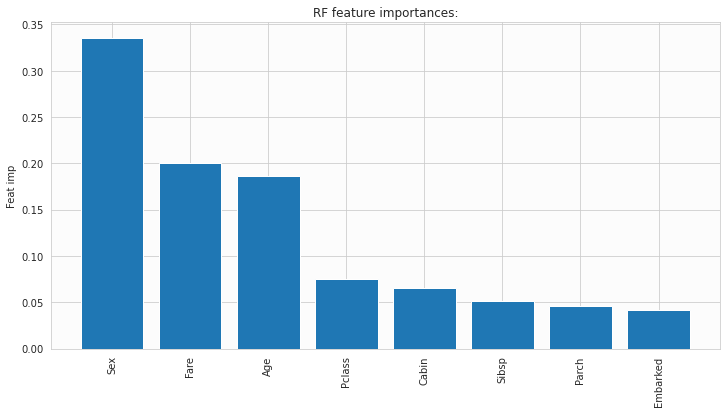

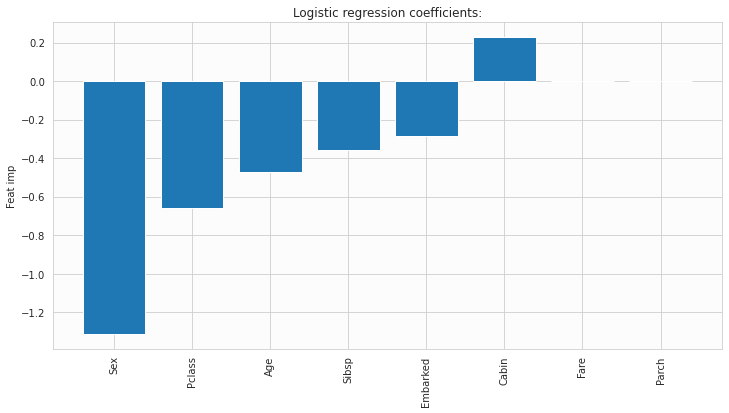

In [20]:
def plot_feat_imp(features, feat_imp):
    
    _, ax = plt.subplots()
    sort_idx = np.absolute(feat_imp).argsort()[::-1].astype(int)
    
    if not isinstance(features, np.ndarray):
        features = np.array(features)
        
    xticks = np.arange(len(feat_imp))
    ax.bar(xticks, feat_imp[sort_idx].astype(float))
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels=features[sort_idx], rotation=90)
    ax.set_ylabel('Feat imp')
    return ax
    
        


ax = plot_feat_imp(features, rf_best_.feature_importances_)
ax.set_title('RF feature importances:')
plt.show()
ax = plot_feat_imp(features, lgreg.coef_[0])
_ = ax.set_title('Logistic regression coefficients:')

In [21]:
from sklearn.metrics import accuracy_score

def report_clf(subfeatures, clf, X_train, X_valid, key):
    
    subfeatures = [f + '_{}'.format(key) for f in subfeatures]
    
    
    clf.fit(X_train.loc[:, subfeatures], y_train_)
    print('Accuracy: {:.4f}'.format(accuracy_score(y_valid_, 
                                                   clf.predict(X_valid.loc[:, subfeatures]))))
    print()

In [22]:
from sklearn.base import clone

feat_imp_rf = rf_best_.feature_importances_.copy()
rf = clone(rf_best_)

sorted_feat_rf = features[np.absolute(feat_imp_rf).argsort()][::-1]

for i in range(1,len(sorted_feat_rf)+1):
    print('{} - Nfeat {}:'.format(rf, i))
    print(*sorted_feat_rf[:i], end='--> \n')
    report_clf(sorted_feat_rf[:i], rf, X_train_enc, X_valid_enc, 'enc')

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 1:
Sex--> 
Accuracy: 0.7642

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 2:
Sex Fare--> 
Accuracy: 0.7683

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 3:
Sex Fare Age--> 
Accuracy: 0.7805

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 4:
Sex Fare Age Pclass--> 
Accuracy: 0.7886

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 5:
Sex Fare Age Pclass Cabin--> 
Accuracy: 0.7967

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 6:
Sex Fare Age Pclass Cabin Sibsp--> 
Accuracy: 0.7967

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 7:
Sex Fare Age Pclass Cabin Sibsp Parch--> 
Accuracy: 0.8130

RandomForestClassifier(max_depth=10, random_state=34) - Nfeat 8:
Sex Fare Age Pclass Cabin Sibsp Parch Embarked--> 
Accuracy: 0.8008



In [23]:
sorted_feat_lg = features[np.absolute(lgreg.coef_[0]).argsort()][::-1]
for i in range(1,len(sorted_feat_lg)+1):
    print('{} - Nfeat {}:'.format(lgreg, i))
    print(*sorted_feat_lg[:i], end='--> \n')
    report_clf(sorted_feat_lg[:i], lgreg, X_train_sc, X_valid_sc, 'sc')

LogisticRegression() - Nfeat 1:
Sex--> 
Accuracy: 0.7642

LogisticRegression() - Nfeat 2:
Sex Pclass--> 
Accuracy: 0.7642

LogisticRegression() - Nfeat 3:
Sex Pclass Age--> 
Accuracy: 0.7724

LogisticRegression() - Nfeat 4:
Sex Pclass Age Sibsp--> 
Accuracy: 0.7805

LogisticRegression() - Nfeat 5:
Sex Pclass Age Sibsp Embarked--> 
Accuracy: 0.7886

LogisticRegression() - Nfeat 6:
Sex Pclass Age Sibsp Embarked Cabin--> 
Accuracy: 0.7886

LogisticRegression() - Nfeat 7:
Sex Pclass Age Sibsp Embarked Cabin Fare--> 
Accuracy: 0.7886

LogisticRegression() - Nfeat 8:
Sex Pclass Age Sibsp Embarked Cabin Fare Parch--> 
Accuracy: 0.7886



#### The final score is rerorted by this - you can provide your own train and test sets, but remember make sure the indexing matches the ones in y_train_ and y_test_:

You will be supplied with a random state in the beginning of the presentation so the train, valid, and test sets will change - you won't be able to tune for optimal test set performance even if you tried. Moreover, try different random_states yourselve since this can reveal some issues in the preprocessing pipe you have devised.

In [24]:
def report_final_result(model, X_train, X_test):
    
    model.fit(X_train, y_train_)
    preds =  model.predict(X_test)

    print('Score: {:.5f}'.format(accuracy_score(y_test_, preds)))
    print('Dummy: {:.5f}'.format(accuracy_score(y_test_, dummy_clf(X_test_))))

In [25]:
nfeat = 4
selected_features_rf = [f + '_enc' for f  in sorted_feat_rf[:nfeat]]
rf = clone(rf_best_)
print('Using features:', *selected_features_rf)

report_final_result(rf, 
                    X_train_enc.loc[:, selected_features_rf], 
                    X_test_enc.loc[:, selected_features_rf])





Using features: Sex_enc Fare_enc Age_enc Pclass_enc
Score: 0.77744
Dummy: 0.74390
